Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3361 images belonging to 5 classes.
Found 718 images belonging to 5 classes.
Found 722 images belonging to 5 classes.
Class Weights computed: {0: np.float64(1.585377358490566), 1: np.float64(1.6004761904761904), 2: np.float64(0.5686971235194586), 3: np.float64(1.4004166666666666), 4: np.float64(0.7861988304093567)}

--- PHASE 1: WARMUP TRAINING ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 612ms/step - accuracy: 0.6294 - loss: 1.0352 - val_accuracy: 0.9136 - val_loss: 0.3724
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.8564 - loss: 0.3939 - val_accuracy: 0.9499 - val_loss: 0.1962
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 406ms/step - accuracy: 0.8709 - loss: 0.3355 - val_accuracy: 0.9554 - val_loss: 0.1341
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.9021 - loss: 0.2518 - val_accuracy: 0.9610 - val_loss: 0.1130
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 408ms/step - accuracy: 0.9167 - loss: 0.2248 - val_accuracy: 0.9582 - val_loss: 0.1288

--- PHASE 2: FINE-TUNING ---
Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8373 - loss: 0.4765
Epoch 1: val_accuracy improved from -inf to 0.97354, saving model to best_vehicle_model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 641ms/step - accuracy: 0.8375 - loss: 0.4758 - val_accuracy: 0.9735 - val_loss: 0.0821 - learning_rate: 1

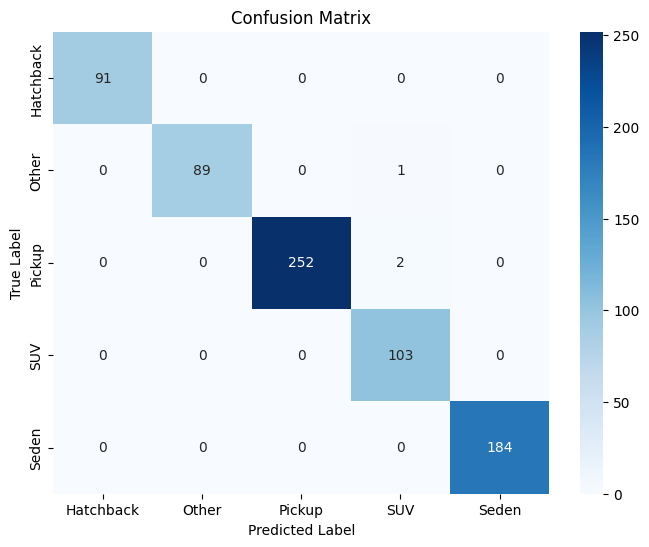

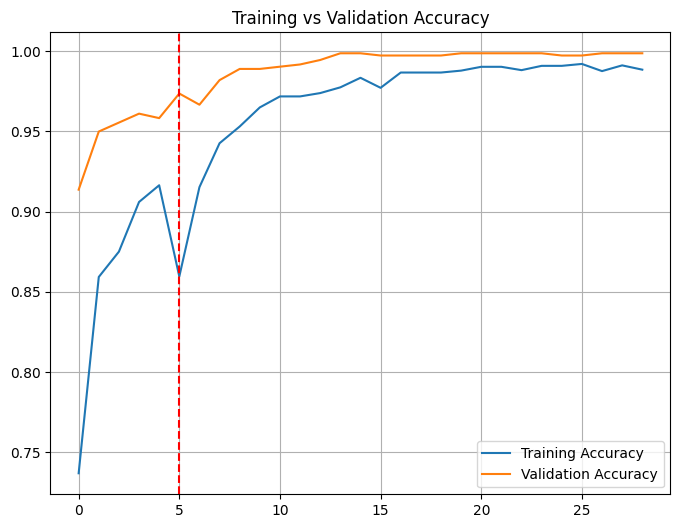

In [6]:
# ==========================================
# STEP 1: SETUP & IMPORTS
# ==========================================
!pip install split-folders
import os
import zipfile
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive')

# ==========================================
# STEP 2: DATA EXTRACTION & SPLIT
# ==========================================
zip_path = '/content/drive/MyDrive/VTID_Final_Project/vtid2_dataset.zip'
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Auto-fix path logic
target_dir = extract_path
while True:
    items = os.listdir(target_dir)
    if any(x in items for x in ['SUV', 'Sedan', 'Bus', 'Pick-up']):
        break
    subfolders = [d for d in items if os.path.isdir(os.path.join(target_dir, d))]
    if not subfolders: break
    target_dir = os.path.join(target_dir, subfolders[0])

# Split Data (70% Train, 15% Val, 15% Test)
if not os.path.exists('output_split'):
    print("Splitting data...")
    splitfolders.ratio(target_dir, output="output_split", seed=1337, ratio=(.7, .15, .15))

# ==========================================
# STEP 3: GENERATORS & CLASS WEIGHTS
# ==========================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# NOTE: We use 'preprocess_input' which is specific to EfficientNet.
# We DO NOT use rescale=1./255 here because preprocess_input handles it internally.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Smart scaling
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'output_split/train', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

validation_generator = test_val_datagen.flow_from_directory(
    'output_split/val', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(
    'output_split/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# --- CALCULATE CLASS WEIGHTS ---
# This balances the model so it doesn't ignore rare classes (e.g., Buses)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
dict_class_weights = dict(enumerate(class_weights))
print(f"Class Weights computed: {dict_class_weights}")

# ==========================================
# STEP 4: MODEL BUILDING (2-STAGE STRATEGY)
# ==========================================

# --- BUILD MODEL ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezing Base for Phase 1
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) # Stabilizes training
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)         # Prevents overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- PHASE 1: WARMUP (Train only the Head) ---
print("\n--- PHASE 1: WARMUP TRAINING ---")
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_warmup = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Short run just to initialize weights
    class_weight=dict_class_weights
)

# --- PHASE 2: FINE-TUNING (Train the whole body) ---
print("\n--- PHASE 2: FINE-TUNING ---")

# Unfreeze the top 30 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Callbacks for fine-tuning
checkpoint = ModelCheckpoint(
    'best_vehicle_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Recompile with very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25, # Higher epochs, but EarlyStopping will cut it short if needed
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=dict_class_weights
)

# ==========================================
# STEP 5: EVALUATION & RESULTS
# ==========================================
print("\n--- GENERATING REPORT ---")

# Load the absolute best model saved by the checkpoint
best_model = load_model('best_vehicle_model.keras')

# Predict
Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = list(test_generator.class_indices.keys())

# 1. Classification Report
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# 2. Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Plot Training History (Accuracy)
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.axvline(x=5, color='r', linestyle='--', label='Fine-Tuning Start') # Mark where Phase 2 started
plt.show()

In [7]:
from google.colab import files

# Download the best checkpoint found during training
files.download('best_vehicle_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>